In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
# from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

# from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
# from lsst.meas.algorithms.detection import SourceDetectionTask
# from lsst.meas.deblender import SourceDeblendTask
# from lsst.meas.base import SingleFrameMeasurementTask
# from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

In [2]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/taceroc/custom_coadd_test_3_422025',
               'u/taceroc/custom_coadd_test_2_442025',
               'u/taceroc/test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025',
               'u/taceroc/test_LEinjection_inputs_1_442025_custom_coadd_test_2_442025'
              ]

In [3]:
butler = Butler(repo, collections=collections)

In [4]:
injection_refs = butler.registry.queryDatasets("injection_catalog")
# injection_catalogs = [
#     calexp_butler.get(injection_ref) for injection_ref in injection_refs
# ]

In [5]:
injection_catalogs = [
    butler.get(injection_ref) for injection_ref in injection_refs
]

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo/u/taceroc/test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025/injection_catalog/g/injection_catalog_g_147173_u_taceroc_test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025.parq'

In [ ]:
injection_catalogs[1]

In [ ]:
injection_catalogs[0]

In [ ]:
injection_catalogs[0]['mag'] = 22
injection_catalogs[0]['stamp'] = 'fits/surface_valuesInfPlane_dt0_loop_ct365_loc[2, 1.3, 1, -326.156]_dz0.06_w673_angle[150, 220].fits'

In [ ]:
injection_catalogs[1]['mag'] = 22
injection_catalogs[1]['stamp'] = 'fits/surface_valuesInfPlane_dt0_loop_ct600_loc[2, 1.3, 1, -326.156]_dz0.06_w673_angle[150, 220].fits'


In [6]:
coadds_refs = butler.registry.queryDatasets("deepCoadd")


In [7]:
list(coadds_refs)

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_3_422025/20250402T165424Z', id=f47ba585-ce1a-47b2-9e7c-c70fa191317f),
 DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=63fc527d-54e0-4203-9080-31287c23b4fe)]

In [8]:
coadds_catalogs = [
    butler.get(coadds_ref) for coadds_ref in coadds_refs
]

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo/u/taceroc/custom_coadd_test_3_422025/20250402T165424Z/deepCoadd/4849/31/g/deepCoadd_4849_31_g_DC2_u_taceroc_custom_coadd_test_3_422025_20250402T165424Z.fits'

In [ ]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

# coadd = coadds_catalogs[0]
psf = coadds_catalogs[0].getPsf()
photo_calib = coadds_catalogs[0].getPhotoCalib()
wcs = coadds_catalogs[0].getWcs()

injected_output_1st = inject_task.run(
    injection_catalogs=injection_catalogs[0],
    input_exposure=coadds_catalogs[0].clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_1st = injected_output_1st.output_exposure
injected_catalog_1st = injected_output_1st.output_catalog

In [14]:
coadds_catalogs[1]

In [15]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

# coadd = coadds_catalogs[1]
psf = coadds_catalogs[1].getPsf()
photo_calib = coadds_catalogs[1].getPhotoCalib()
wcs = coadds_catalogs[1].getWcs()

injected_output_2nd = inject_task.run(
    injection_catalogs=injection_catalogs[1],
    input_exposure=coadds_catalogs[1].clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_2nd = injected_output_2nd.output_exposure
injected_catalog_2nd = injected_output_2nd.output_catalog

In [16]:
injected_coadd_1st = injected_exposure_1st.clone()
injected_coadd_2nd = injected_exposure_2nd.clone()

In [17]:
src_refs = butler.registry.queryDatasets("deepCoadd_meas")
src_catalog = [butler.get(src_ref) for src_ref in src_refs]

In [18]:
list(src_refs)

[DatasetRef(DatasetType('deepCoadd_meas', {band, skymap, tract, patch}, SourceCatalog), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=fb47e7e5-aca5-4c03-badb-9ab31a478fc2)]

In [19]:
# deepCoadd_src = simpleButler.get(list(simpleButler.registry.queryDatasets('deepCoadd_meas'))[0])

In [20]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)

result = alTask.run(injected_coadd_1st, injected_coadd_2nd, src_catalog[0])

Could not apply source flag: "Field with name 'sky_source' not found"


In [21]:
# older injection: INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025"
# newer injection: INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_1_442025_custom_coadd_test_2_442025"

In [22]:
injection_catalogs[1]['ra'].value[0]*geom.degrees

Angle(53.710000000000001, degrees)

In [23]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

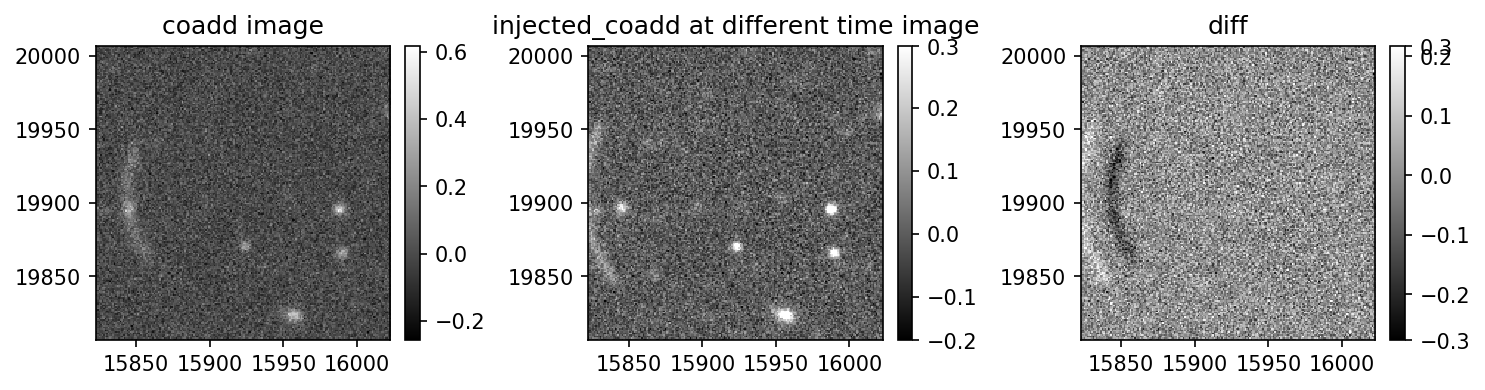

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)
coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
# display0.scale('linear', min=-0.2, max=0.1)
display0.mtv(injected_coadd_1st.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('coadd image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')

# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')
display1.mtv(injected_coadd_2nd.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('injected_coadd at different time image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('diff')

plt.tight_layout()
plt.show()

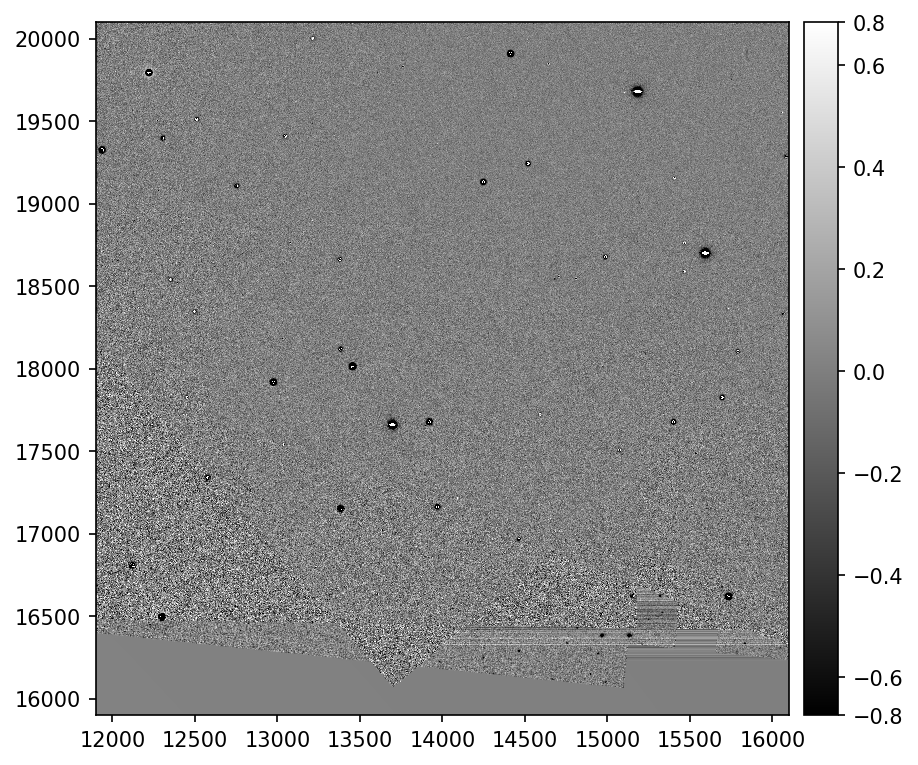

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(result.difference.image)
# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')


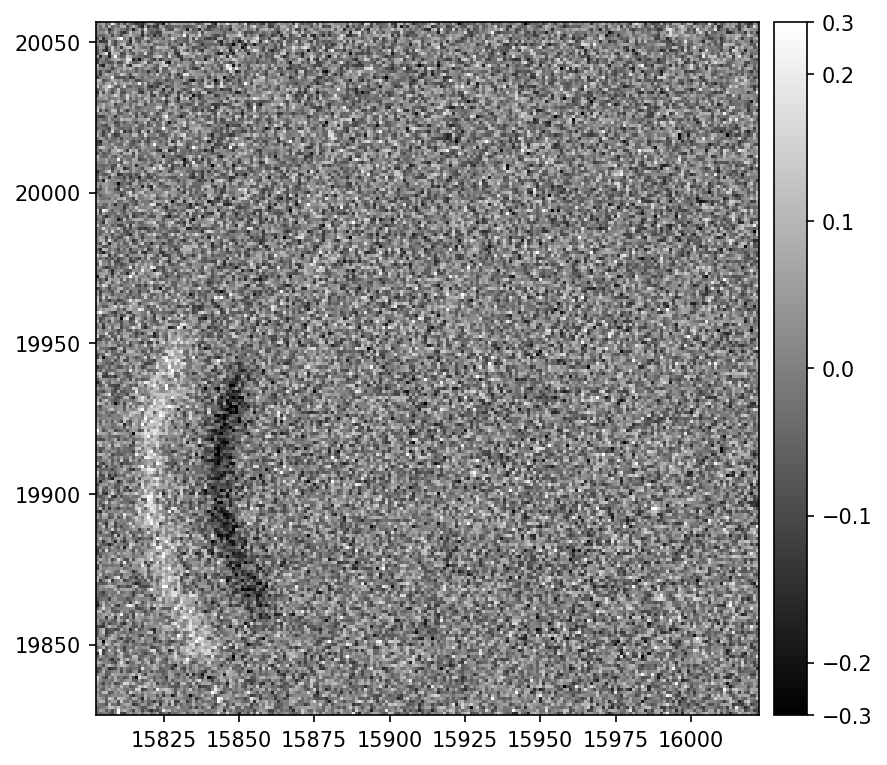

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
# coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(result.difference.image[coordiante.x+100:coordiante.x-120, coordiante.y+150:coordiante.y-80])
# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')